In [1]:
import muon as mu
from muon import atac as ac
import numpy as np
import scanpy as sc
import episcanpy as epi

In [24]:
rna = sc.read_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/Muto-2021-RNA.h5ad")
atac = sc.read_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/Muto-2021-ATAC.h5ad")

In [25]:
rna

AnnData object with n_obs × n_vars = 19985 × 27146
    obs: 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'donor_uuid', 'ethnicity_ontology_term_id', 'library_uuid', 'mapped_reference_annotation', 'organism_ontology_term_id', 'sample_preservation_method', 'sample_uuid', 'suspension_type', 'suspension_uuid', 'tissue_ontology_term_id', 'is_primary_data', 'author_cell_type', 'cell_type_category', 'cell_type_ontology_term_id', 'author_cluster', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'percent.mt', 'percent.rpl', 'percent.rps', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'domain', 'protocol', 'dataset', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_c

In [26]:
atac

AnnData object with n_obs × n_vars = 24205 × 99019
    obs: 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'donor_uuid', 'ethnicity_ontology_term_id', 'library_uuid', 'organism_ontology_term_id', 'sample_preservation_method', 'sample_uuid', 'suspension_type', 'suspension_uuid', 'tissue_ontology_term_id', 'is_primary_data', 'author_cell_type', 'cell_type_category', 'cell_type_ontology_term_id', 'author_cluster', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'domain', 'protocol', 'dataset', 'batch'
    var: 'chrom', 'chromStart', 'chromEnd', 'genome', 'n_counts'
    uns: 'X_normalization', 'default_embedding', 'layer_descriptions', 'schema_version', 'title'
    obsm: 'X_umap'

deal with scRNA data

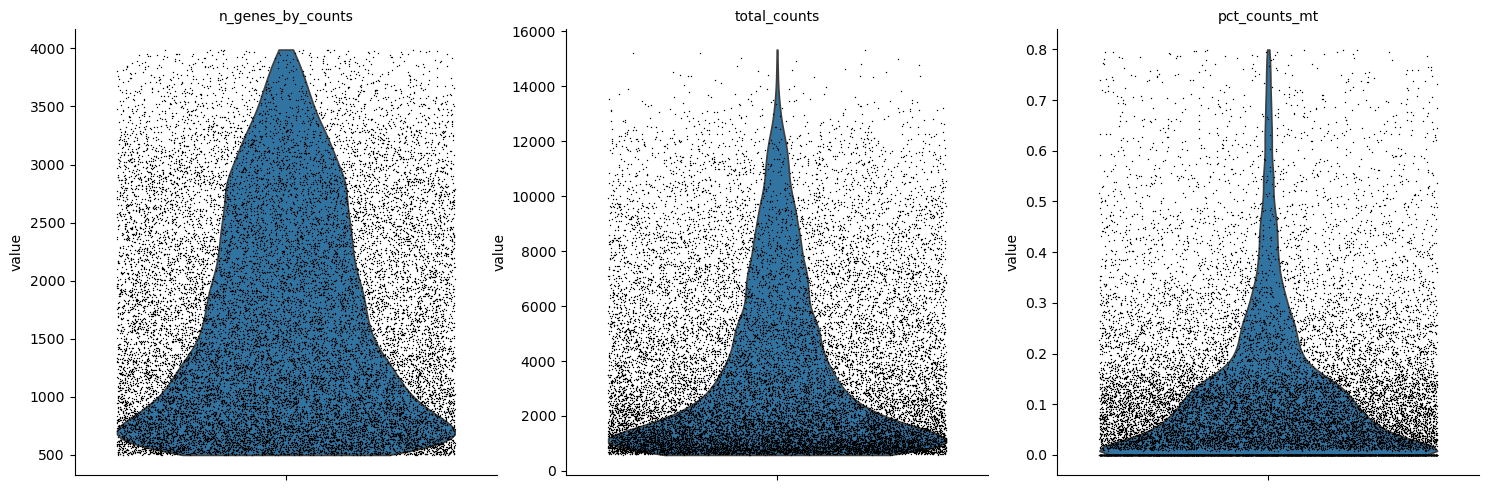

In [27]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [28]:
# mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
# mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

# sc.pp.filter_genes(rna, min_cells=3)
# sc.pp.filter_cells(rna, min_genes=200)
# sc.pp.filter_cells(rna, max_genes=5000)
# sc.pp.filter_cells(rna, max_counts=15000)
# rna = rna[rna.obs['pct_counts_mt'] < 20, :]
rna.layers['counts'] = rna.X.copy()

In [29]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, batch_key="batch", min_mean=0.02, max_mean=4, min_disp=0.5)
genelist = rna.var.index[rna.var['highly_variable']==True]

deal with scATAC data

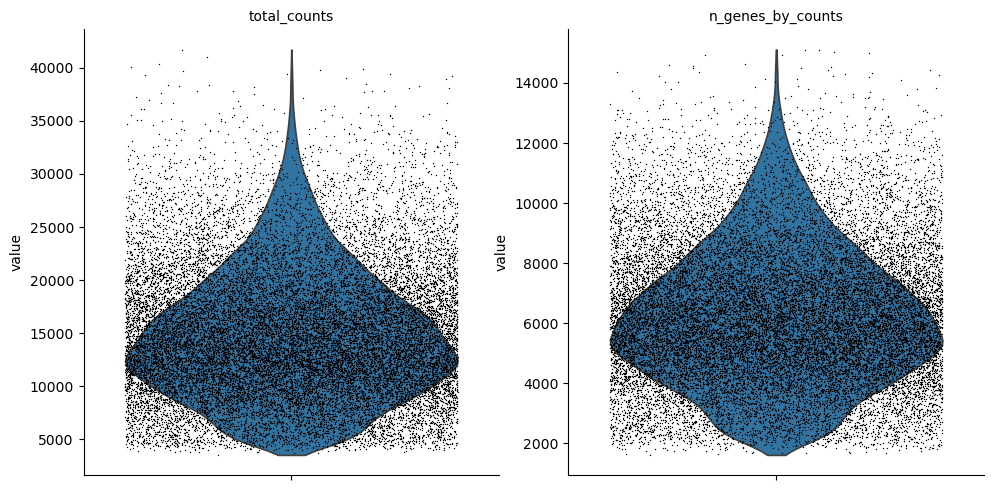

In [31]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [32]:
# mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))

# sc.pp.filter_genes(atac, min_cells=10)
# sc.pp.filter_cells(atac, min_genes=2000)
# sc.pp.filter_cells(atac, max_genes=15000)
atac.layers["counts"] = atac.X.copy()

In [33]:
ac.pp.tfidf(atac, scale_factor=1e4)
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5, batch_key="batch")
peaklist = atac.var.index[atac.var['highly_variable']==True]

combine data

In [34]:
# data after QC
rna.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/muto/RNA_counts_qc.h5ad")
atac.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/muto/ATAC_counts_qc.h5ad")

In [66]:
atac = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/muto/ATAC_counts_qc.h5ad")
atac.layers['normalized'] = atac.X.copy()
atac.X = atac.layers['counts'].copy()
atac_gas = epi.tl.geneactivity(atac, "/ailab/user/sunjianle-hdd/integration27/BMMC/gencode.v38.primary_assembly.annotation.gtf",annotation='HAVANA')
atac_gas = atac_gas[:, ~atac_gas.var_names.duplicated()]

In [67]:
atac_gas.layers['counts'] = atac_gas.X.copy()
# ac.pp.tfidf(atac_gas, scale_factor=1e4)
sc.pp.normalize_total(atac_gas)
sc.pp.log1p(atac_gas)
sc.pp.highly_variable_genes(atac_gas, batch_key="batch") #, min_mean=0.05, max_mean=1.5, min_disp=.5
peaklist = atac_gas.var.index[atac_gas.var['highly_variable']==True]

In [68]:
atac_gas.write("/ailab/user/sunjianle-hdd/integration27/mop/muto/ATAC_gas.h5ad")

In [69]:
rna = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/muto/RNA_counts_qc.h5ad")
genelist = rna.var.index[rna.var['highly_variable']==True]
genelist2 = list((set(peaklist) | set(genelist)) & set(atac_gas.var_names) & set(rna.var_names))

In [70]:
len(genelist2)

4978

In [71]:
genelist3 = list((set(peaklist) & set(genelist)) & set(atac_gas.var_names) & set(rna.var_names))
len(genelist3)

882

In [72]:
import anndata as ad
adata = ad.concat([rna,atac_gas], join='inner', label="modality")
adata

AnnData object with n_obs × n_vars = 44190 × 17435
    obs: 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'donor_uuid', 'ethnicity_ontology_term_id', 'library_uuid', 'organism_ontology_term_id', 'sample_preservation_method', 'sample_uuid', 'suspension_type', 'suspension_uuid', 'tissue_ontology_term_id', 'is_primary_data', 'author_cell_type', 'cell_type_category', 'cell_type_ontology_term_id', 'author_cluster', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'domain', 'protocol', 'dataset', 'batch', 'n_genes_by_counts', 'total_counts', 'modality'
    obsm: 'X_umap'
    layers: 'counts'

In [73]:
adata.uns['rna_hvg'] = genelist.to_list()
adata.uns['atac_hvg'] = peaklist.to_list()

In [74]:
adata[:,genelist2].write("/ailab/user/sunjianle-hdd/integration27/mop/muto/feature_aligned.h5ad")

In [43]:
adata = sc.read_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/muto/feature_aligned.h5ad")

In [2]:
atac_gas = sc.read_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/muto/ATAC_gas.h5ad")
rna = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/muto/RNA_counts_qc.h5ad")
genelist = rna.var.index[rna.var['highly_variable']==True]
peaklist = atac_gas.var.index[atac_gas.var['highly_variable']==True]
genelist2 = list((set(peaklist) | set(genelist)) & set(atac_gas.var_names) & set(rna.var_names))

In [3]:
# atac_gas = atac_gas[:,genelist2]
# rna = rna[:,genelist2]
# sc.pp.scale(atac_gas)
# sc.pp.scale(rna)

In [5]:
import anndata as ad
adata = ad.concat([rna,atac_gas], join='inner', label="modality")
adata.uns['rna_hvg'] = genelist.to_list()
adata.uns['atac_hvg'] = peaklist.to_list()
adata[:,genelist2].write("/ailab/user/sunjianle-hdd/integration27/mop/muto/feature_aligned.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 44190 × 17435
    obs: 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'donor_uuid', 'ethnicity_ontology_term_id', 'library_uuid', 'organism_ontology_term_id', 'sample_preservation_method', 'sample_uuid', 'suspension_type', 'suspension_uuid', 'tissue_ontology_term_id', 'is_primary_data', 'author_cell_type', 'cell_type_category', 'cell_type_ontology_term_id', 'author_cluster', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'domain', 'protocol', 'dataset', 'batch', 'n_genes_by_counts', 'total_counts', 'modality'
    uns: 'rna_hvg', 'atac_hvg'
    obsm: 'X_umap'
    layers: 'counts'

In [60]:
adata = sc.read_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/muto/feature_aligned.h5ad")

array([[-0.20159216,  1.073836  , -0.25803414, ..., -0.22304595,
        -0.04457624, -0.01400112],
       [-0.20159216, -0.5587765 , -0.25803414, ..., -0.22304595,
        -0.04457624, -0.01400112],
       [-0.20159216, -0.5587765 , -0.25803414, ..., -0.22304595,
        -0.04457624, -0.01400112],
       ...,
       [-0.35610422, -1.1346993 ,  2.475634  , ..., -0.36267865,
        -0.24481855, -0.16675703],
       [-0.35610422, -1.1346993 , -0.7998284 , ..., -0.36267865,
        -0.24481855, -0.16675703],
       [ 2.4730146 , -1.1346993 ,  0.6894704 , ..., -0.36267865,
        -0.24481855, -0.16675703]], dtype=float32)